# Interpretable Clustering

**Creators**:
- Oleksandr Makarevych (O.Makarevych@campus.lmu.de)
- Ozgecan Gumusbas (ozgecan.gumusbas@campus.lmu.de)
- Selen Erkan (erkan.selen@campus.lmu.de)

**BMW Supervisor**: Maka Karalashvili (Maka.Karalashvili@bmw.de)

**LMU Supervisor**: Goeran Kauermann (goeran.kauermann@stat.uni-muenchen.de)

**Goal of the project** is to provide a Proof of Concept for interpretable clustering. 

It is often the case that clustering can be explained in terms of mathematical functions or equations. However, bringing business meaning to a cluster is rather complicated. 

Our team decided to focus on the following approach:
- Choose a dataset (preferably labeled) for training since BMW data is unavailable. 
- Create a clustering of the data
- Use dataset labels to validate clustering
- Assign "true label" to data point as it's cluster label
- Build a decision tree on top of clustering for classification
- Visualize a decision tree using BMW's software (*to be carried out by BMW Supervisor*)

**The assumption is that visualizing decision tree will bring interpretability to clusters as there will be a path and features split leading to a decision.**

The **dataset** chosen for this project is HappyDB (https://www.kaggle.com/datasets/ritresearch/happydb)

Happy DB is a collection of more than 100 000 happy memories from 7 different categories. Each sentence is labelled with a category.

In [53]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
import pickle

In [54]:
!pip install top2vec
!pip install top2vec[sentence_encoders]

In [3]:
!pip install scikit-multilearn

# Top2Vec Demo

First task of the project was to cluster the data and see what the cluster would represent. K-means or other centroid-based algorithms were unadvisable since they would essentially enforce the shape of the cluster.

However, for us it was important to let clusters form themselves from the density of the datapoints where each datapoint is one training sample. 


In order to cluster the data we had to first embed it. As we wanted to use state of the art approach, we decided to use transformer models. 
**Top2Vec** (https://github.com/ddangelov/Top2Vec) caught our eye as a means to not onlyt embed the documents, but to work with document topics and underlying keywords. 
Essentially, Top2Vec gave us an ability to use transformer for encoding and cluster the documents into topics using HDBSCAN, which is a density based clustering algorithm.

In [4]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.25)

In [5]:
happy_memories = pd.read_csv("cleaned_hm.csv")
happy_memories.drop(columns=["original_hm", "ground_truth_category"], inplace=True)
happy_memories.head()

,hmid,wid,reflection_period,cleaned_hm,modified,num_sentence,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,True,1,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,True,1,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,True,1,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,True,2,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,True,1,affection


In [6]:
X = happy_memories['cleaned_hm']
y = happy_memories['predicted_category']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y,test_size=0.25)
#memories_list = happy_memories["cleaned_hm"].tolist()
memories_list = X_train.tolist()

Top2Vec with pretrained embedding model

In [7]:
!pip install top2vec
!pip install top2vec[sentence_encoders]

Universal sentence encoder is just one of the embedding models provided by Top2Vec

In [ ]:
from top2vec import Top2Vec

model = Top2Vec(memories_list, speed="learn", workers=8, embedding_model='universal-sentence-encoder')

2022-04-10 14:25:10,323 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-04-10 14:25:15,523 - top2vec - INFO - Downloading universal-sentence-encoder model
2022-04-10 14:25:34,068 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-04-10 14:26:01,601 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  war

In [ ]:
model.save("top2vec_universal_encoder")

As can be seen, Top2Vec constructed 512 topics out of our 100 000+ docuemnts. For the purposes of later development, each of this topics is treated as a small cluster. This approach makes sense since each topic is just a collection of semantically similar documents. 

In [ ]:
print("Number of topics: ",model.get_num_topics())
topic_sizes, topic_nums = model.get_topic_sizes()

Number of topics:  512


Each topic contains a variable number of documents, as can be seen.

In [ ]:
print(topic_sizes, topic_nums)

[1815  903  873  871  799  769  762  738  702  646  637  598  597  589
  578  563  523  509  493  472  459  457  456  441  435  431  428  424
  422  421  404  399  394  392  391  387  386  385  380  378  366  361
  346  346  344  339  327  320  320  319  318  318  309  308  306  294
  294  279  277  276  275  272  270  268  268  265  265  262  260  259
  256  253  250  249  244  244  241  240  238  236  234  232  232  227
  225  225  222  222  222  220  220  220  220  219  217  216  215  214
  212  212  210  209  204  203  203  201  201  200  200  196  196  196
  195  195  194  194  192  188  187  185  184  182  182  182  181  180
  179  178  176  176  176  176  176  175  174  173  173  172  172  171
  170  167  167  166  166  165  165  163  162  162  161  160  158  157
  157  155  155  154  154  152  152  151  150  149  149  149  149  147
  147  147  146  146  145  143  143  142  141  138  138  138  138  137
  136  136  136  135  135  135  134  134  134  134  133  133  132  130
  128 

Documents relevant to the topic can be searched via topic number. In this example, we return 5 top documents from topic 48.
Each data point has an index from original DataFrame, cosine similarity score to the topic and the sentence itself.

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=48, num_docs=5)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 36008, Score: 0.898632287979126
-----------
I went to eat at my favorite restaurant.
-----------

Document: 28399, Score: 0.893478512763977
-----------
I went to eat at a restaurant that I really liked.
-----------

Document: 39061, Score: 0.8902791738510132
-----------
I went to my favorite restaurant for dinner.
-----------

Document: 67854, Score: 0.8721799254417419
-----------
I had a delicious meal at my favorite restaurant.
-----------

Document: 57973, Score: 0.8710365295410156
-----------
I went out to eat at my favorite restaurant with friends.
-----------



Aditionally, Top2Vec provides means to print top 50 keywords for each topic. 

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(7)

Here we can see the top words for the first 7 topics.

In [ ]:
topic_words

array([['dog', 'puppy', 'dogs', ..., 'gotten', 'couch', 'watching'],
       ['graduated', 'graduating', 'exams', ..., 'masters', 'career',
        'went'],
       ['birthday', 'celebrating', 'anniversary', ..., 'enjoying',
        'relatives', 'husband'],
       ...,
       ['anniversary', 'dinner', 'restaurant', ..., 'had', 'meeting',
        'tasty'],
       ['yesterday', 'thanked', 'gave', ..., 'happened', 'definitely',
        'needed'],
       ['ran', 'marathon', 'mile', ..., 'finally', 'completed', 'played']],
      dtype='<U14')

Aditionally Top2Vec provides functionality to find topics most similar to the specified keyword.
These topics can then be used to visualize word clouds representing the topic.

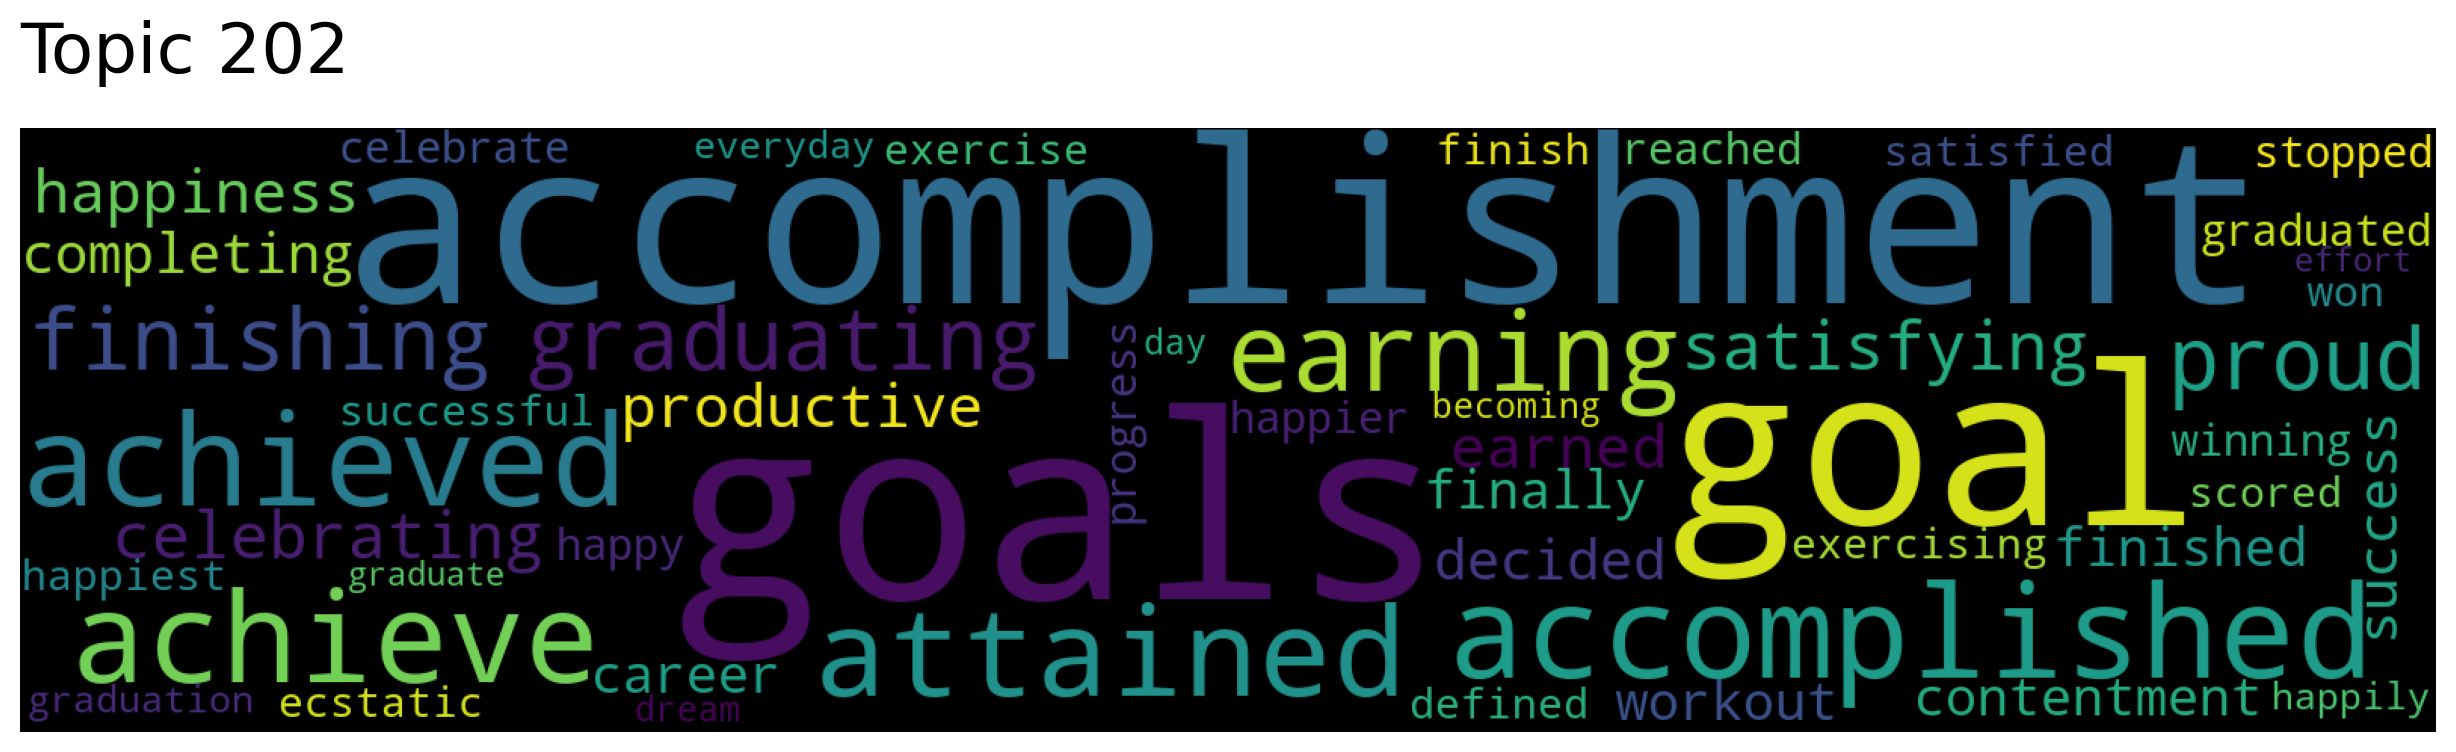

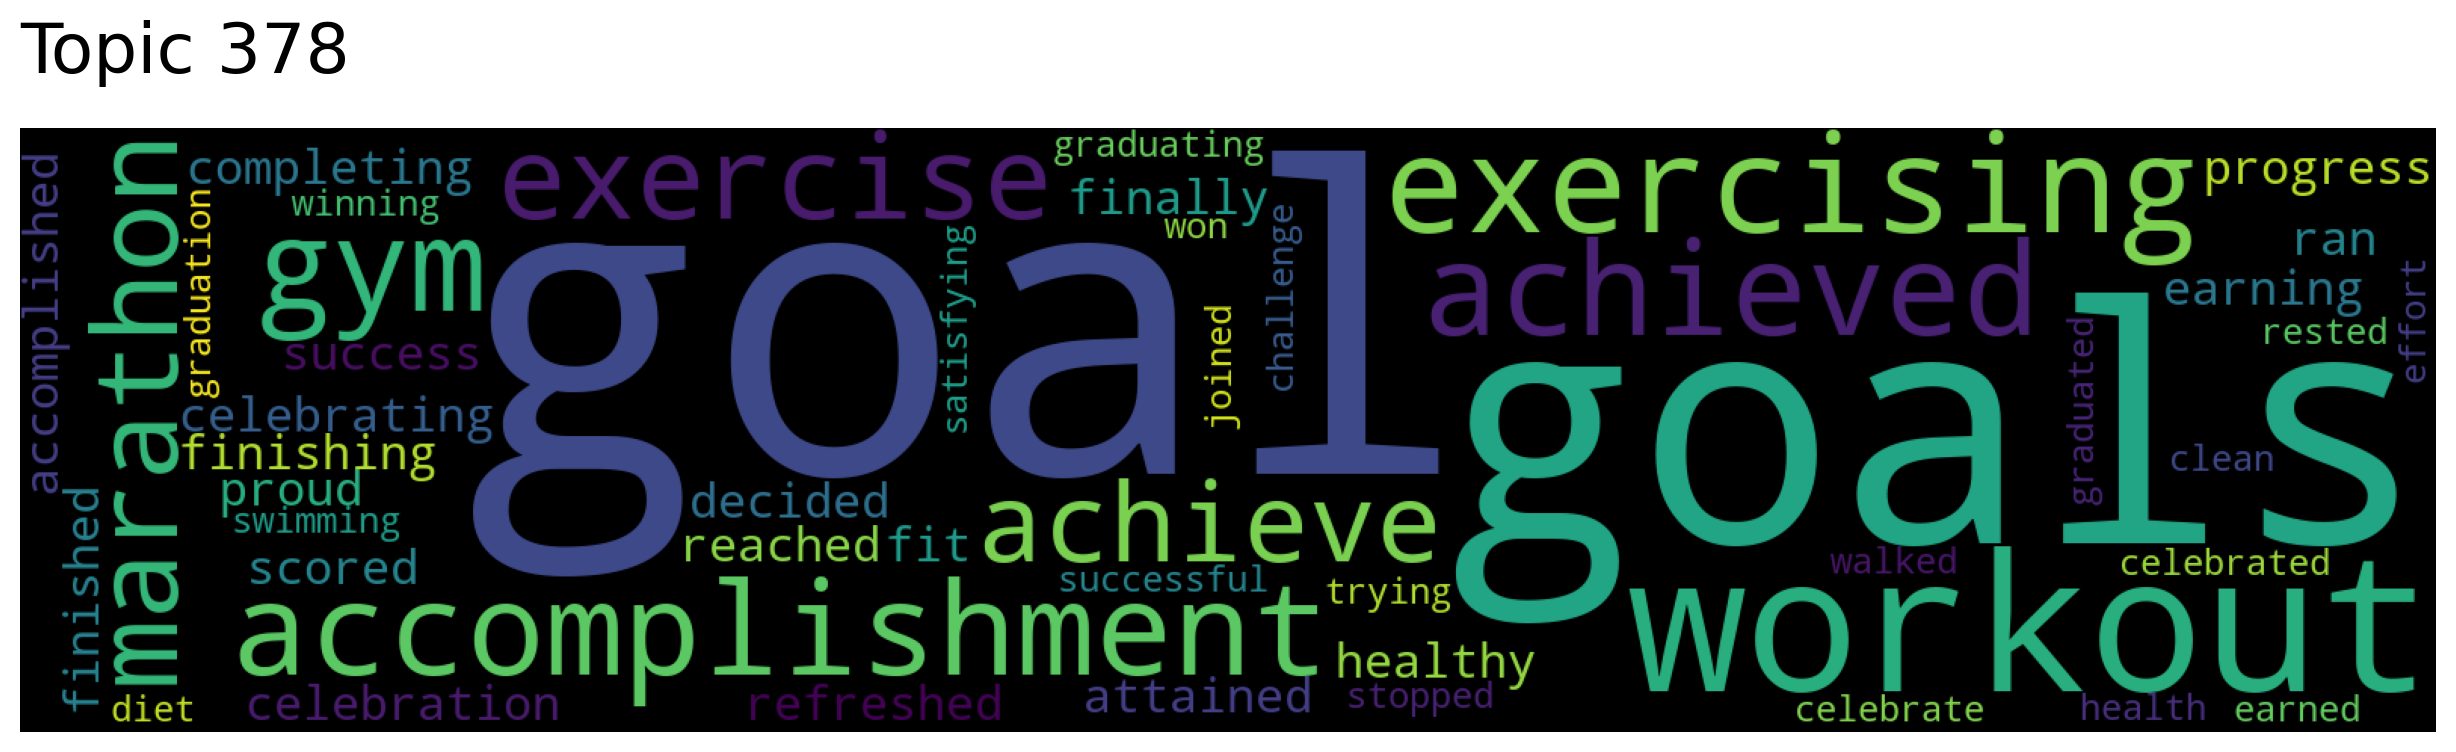

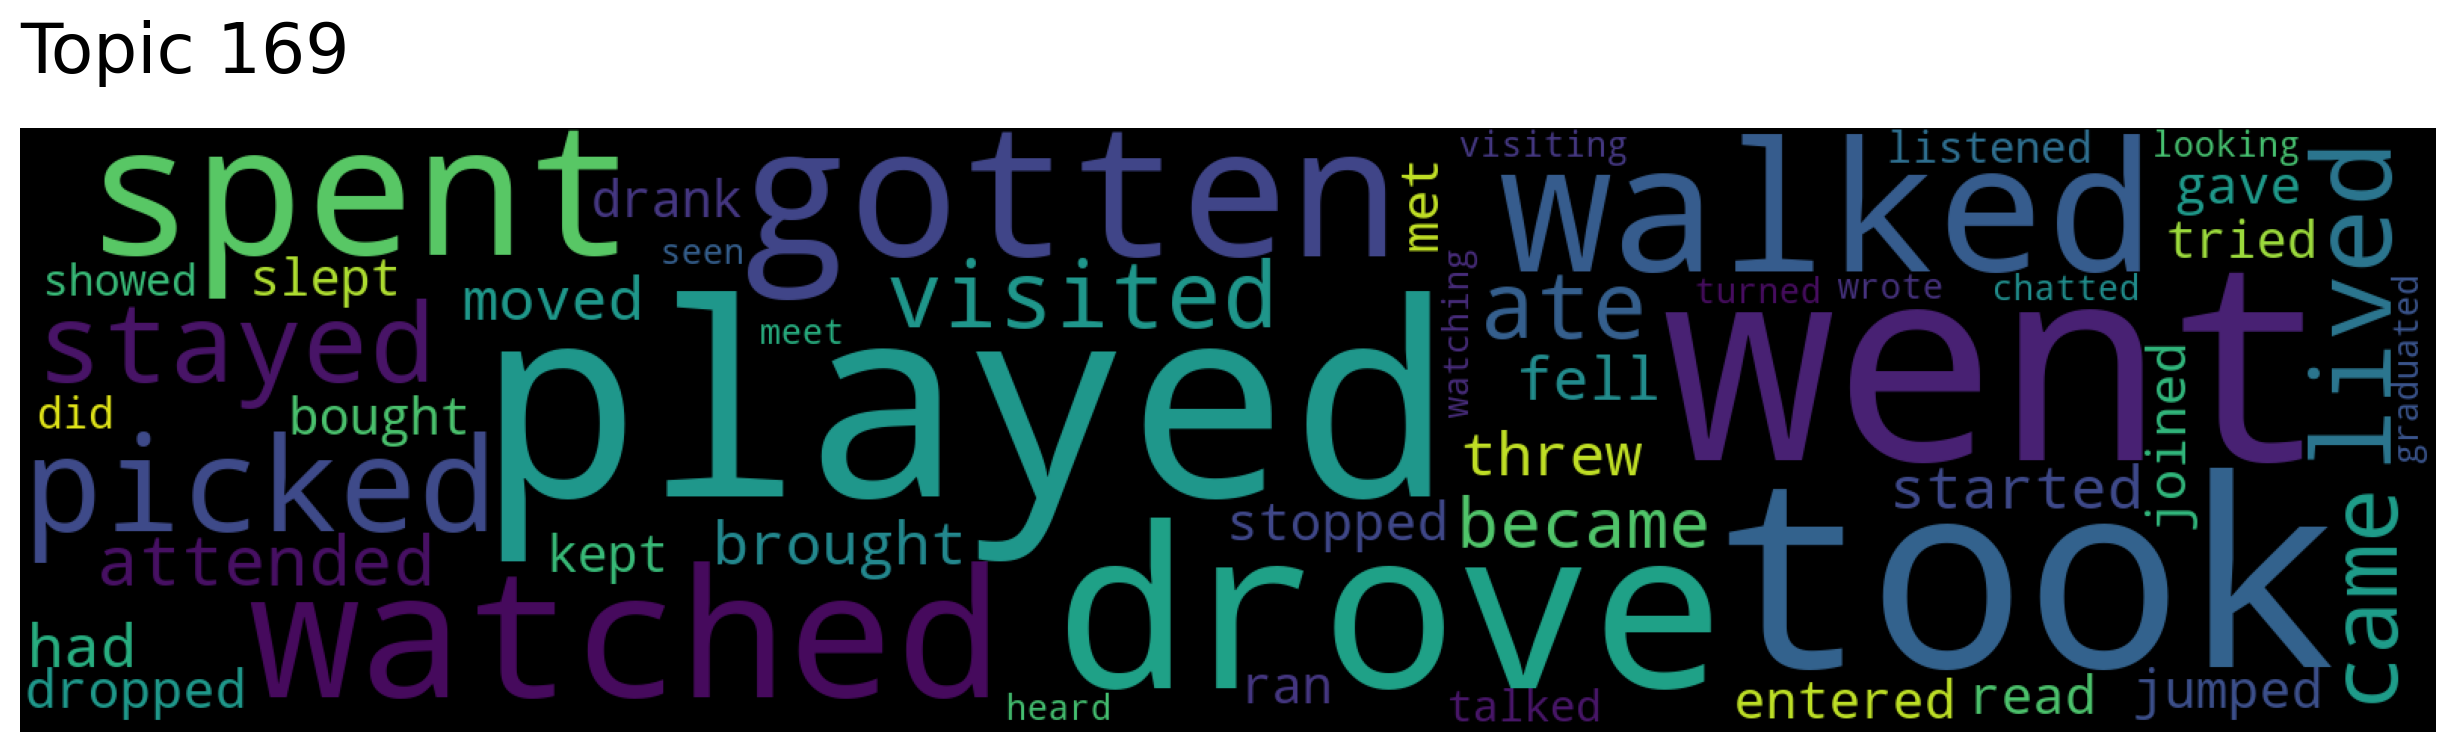

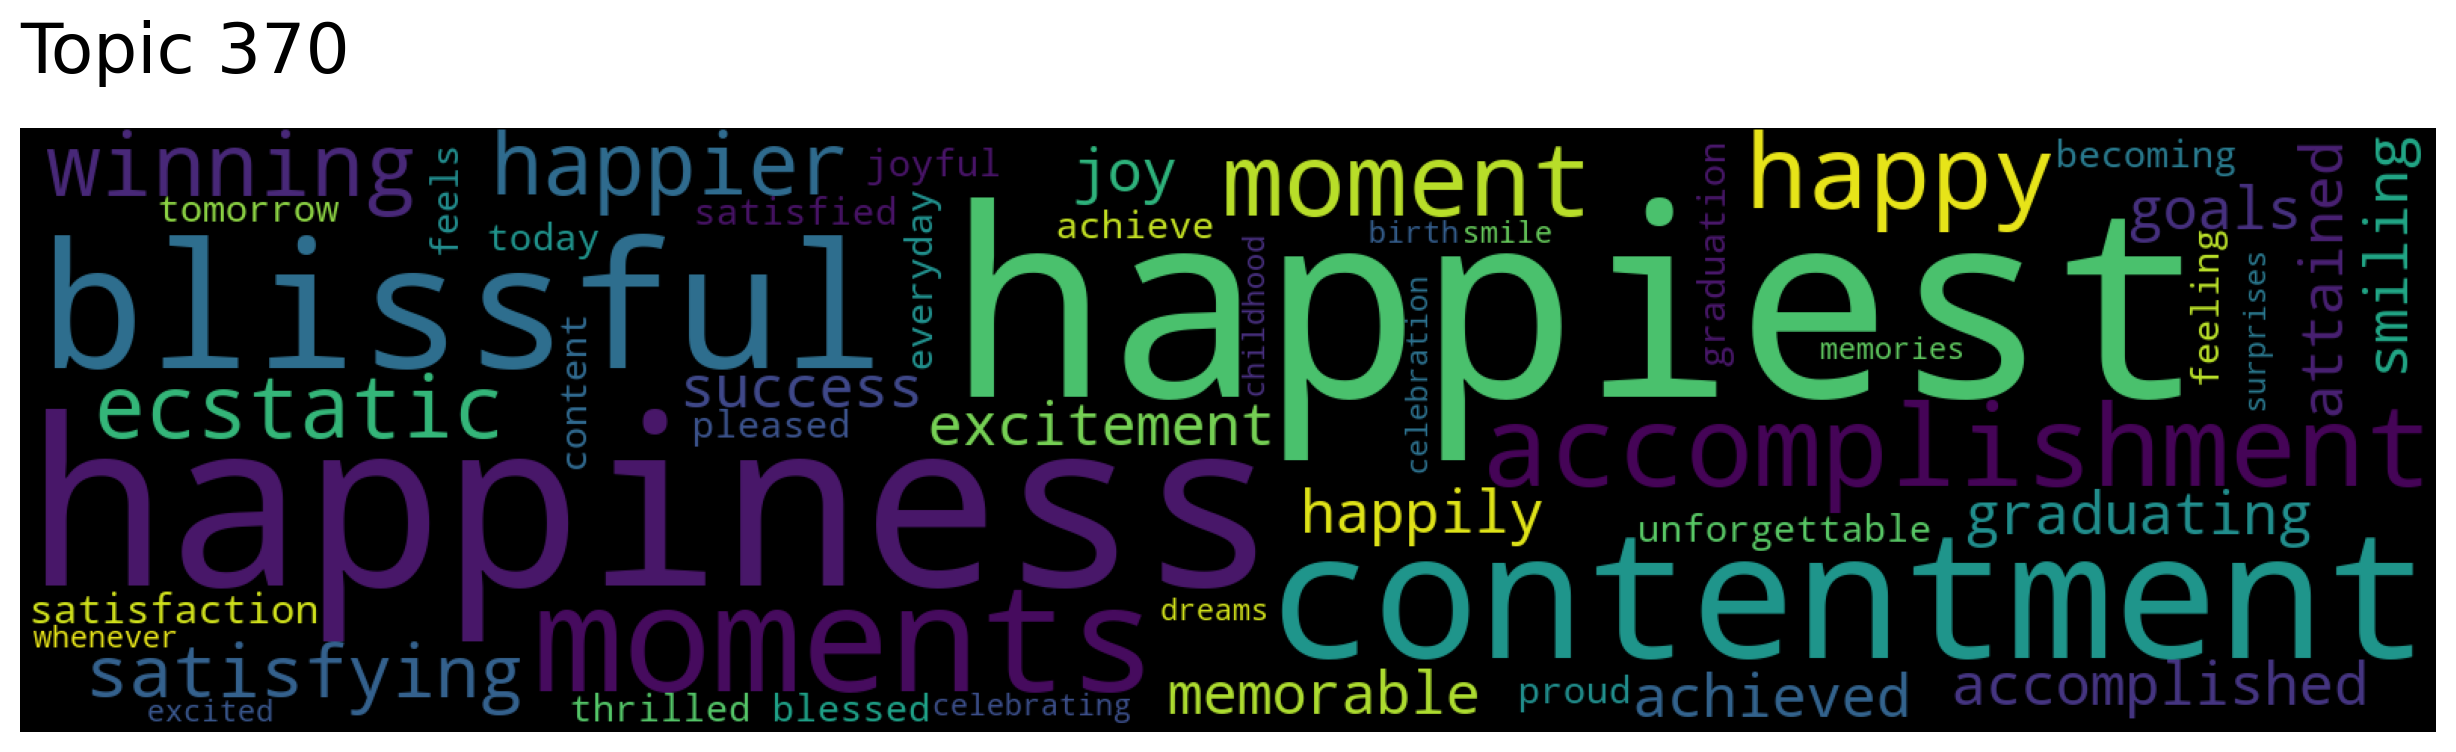

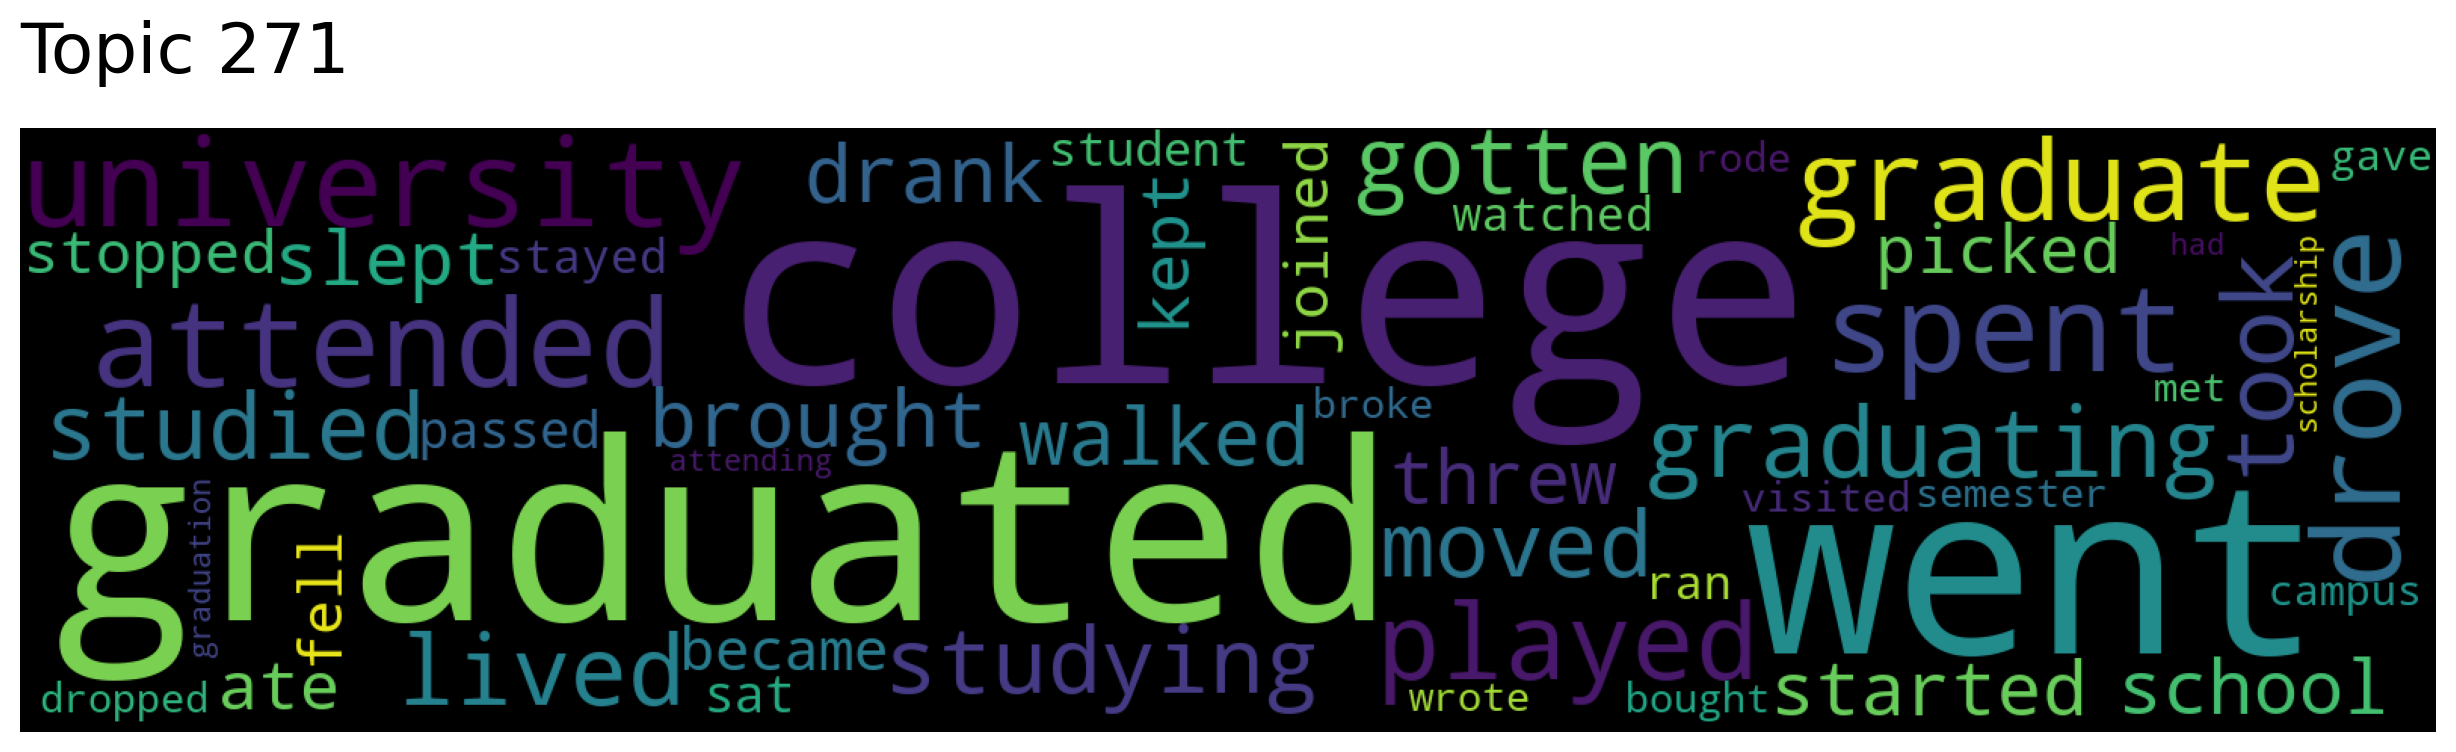

In [ ]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["achieve"], num_topics=5)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

# Clusters Merging

Second step of the project is to cluster some of the semantically similar smaller clusters into bigger ones. Ideally, we should get exactly 7 clusters after merging smaller clusters into bigger ones.

In [4]:
happy_memories = pd.read_csv("cleaned_hm.csv")
memories_list = happy_memories["cleaned_hm"].tolist()

In [5]:
from top2vec import Top2Vec

model = Top2Vec(memories_list, speed="learn", workers=8, embedding_model='universal-sentence-encoder')

2022-04-24 14:10:59,927 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2022-04-24 14:11:16,566 - top2vec - INFO - Downloading universal-sentence-encoder model
2022-04-24 14:11:27,518 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2022-04-24 14:11:59,849 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  war

In [9]:
model.save("top2vec_universal_encoder")

In [10]:
print("Number of topics: ",model.get_num_topics())
topic_sizes, topic_nums = model.get_topic_sizes()

Number of topics:  641


In [11]:
topic_sizes

array([1212, 1188, 1168, 1160, 1133, 1039,  891,  755,  720,  698,  671,
        661,  618,  614,  599,  592,  591,  563,  560,  555,  552,  545,
        527,  519,  514,  507,  506,  494,  485,  483,  482,  480,  463,
        456,  453,  451,  444,  440,  428,  425,  424,  421,  402,  402,
        395,  394,  392,  382,  369,  365,  364,  363,  362,  357,  356,
        355,  352,  351,  349,  338,  337,  335,  332,  332,  331,  329,
        328,  328,  326,  323,  322,  320,  319,  318,  315,  308,  307,
        307,  306,  304,  303,  302,  300,  298,  296,  296,  289,  285,
        285,  282,  281,  279,  279,  277,  274,  274,  273,  271,  269,
        268,  266,  266,  263,  263,  263,  259,  257,  257,  256,  256,
        254,  253,  252,  251,  250,  250,  249,  248,  246,  246,  246,
        244,  242,  236,  230,  229,  229,  229,  228,  226,  221,  220,
        219,  218,  218,  217,  216,  215,  212,  210,  209,  206,  205,
        204,  203,  202,  202,  202,  201,  200,  2

As can be seen from this code snippet, sometimes small topics (clusters) have data points with multiple labels. As such, it remains unclear what the cluster label should be.

In [12]:
numberOfCorrect = 0
for topic_index in range(len(topic_sizes)):
  print("Topic id: ", topic_index)
  # print("Topic words: ")
  # print(model.topic_words_reduced[topic_index])

  documents, doc_scores, doc_ids = model.search_documents_by_topic(topic_index, num_docs=topic_sizes[topic_index])
  # print(doc_scores[0])
  # print(doc_ids[0])
  # print(documents[0])
  numberOfCorrect += happy_memories.iloc[doc_ids]["predicted_category"].value_counts()[0]
  print(happy_memories.iloc[doc_ids]["predicted_category"].value_counts())
  print("---")

Topic id:  0
achievement         1188
bonding                9
enjoy_the_moment       8
affection              6
exercise               1
Name: predicted_category, dtype: int64
---
Topic id:  1
affection           793
bonding             290
enjoy_the_moment     71
achievement          28
leisure               5
exercise              1
Name: predicted_category, dtype: int64
---
Topic id:  2
nature              880
enjoy_the_moment    127
achievement          87
affection            27
exercise             19
leisure              17
bonding              11
Name: predicted_category, dtype: int64
---
Topic id:  3
affection           963
achievement         174
bonding              22
enjoy_the_moment      1
Name: predicted_category, dtype: int64
---
Topic id:  4
affection           1002
achievement           52
enjoy_the_moment      36
bonding               29
leisure               12
nature                 2
Name: predicted_category, dtype: int64
---
Topic id:  5
enjoy_the_moment    475


In [15]:
happy_memories.iloc[doc_ids]["predicted_category"].value_counts().keys()[0]


'affection'

In [16]:
numberOfCorrect

74693

In [17]:
happy_memories.shape[0]

100535

In [18]:
numberOfCorrect/happy_memories.shape[0]

0.7429551897349181

Here just label types are printed

In [19]:
types_of_emotions = happy_memories["predicted_category"].unique()
for emotion in types_of_emotions:
  print(emotion)

affection
exercise
bonding
leisure
achievement
enjoy_the_moment
nature


In [20]:
cluster_indexes = {
}
for emotion in types_of_emotions:
  cluster_indexes[emotion] = []

In [21]:
cluster_indexes

{'achievement': [],
 'affection': [],
 'bonding': [],
 'enjoy_the_moment': [],
 'exercise': [],
 'leisure': [],
 'nature': []}

In order to solve the problem with cluster label, it has been decided that majority voting can be utilized to assign a label to a cluster. The idea is that for each small cluster the label of the cluster is the label that is most common in the cluster.


In [22]:
for topic_index in range(len(topic_sizes)):
  print("Topic id: ", topic_index)
  # print("Topic words: ")
  # print(model.topic_words_reduced[topic_index])

  documents, doc_scores, doc_ids = model.search_documents_by_topic(topic_index, num_docs=topic_sizes[topic_index])
  # print(doc_scores[0])
  # print(doc_ids[0])
  # print(documents[0])
  # print(happy_memories.iloc[doc_ids]["predicted_category"].value_counts())

  cluster_label = happy_memories.iloc[doc_ids]["predicted_category"].value_counts().keys()[0]
  cluster_indexes[cluster_label] += list(doc_ids)
  print("---")

Topic id:  0
---
Topic id:  1
---
Topic id:  2
---
Topic id:  3
---
Topic id:  4
---
Topic id:  5
---
Topic id:  6
---
Topic id:  7
---
Topic id:  8
---
Topic id:  9
---
Topic id:  10
---
Topic id:  11
---
Topic id:  12
---
Topic id:  13
---
Topic id:  14
---
Topic id:  15
---
Topic id:  16
---
Topic id:  17
---
Topic id:  18
---
Topic id:  19
---
Topic id:  20
---
Topic id:  21
---
Topic id:  22
---
Topic id:  23
---
Topic id:  24
---
Topic id:  25
---
Topic id:  26
---
Topic id:  27
---
Topic id:  28
---
Topic id:  29
---
Topic id:  30
---
Topic id:  31
---
Topic id:  32
---
Topic id:  33
---
Topic id:  34
---
Topic id:  35
---
Topic id:  36
---
Topic id:  37
---
Topic id:  38
---
Topic id:  39
---
Topic id:  40
---
Topic id:  41
---
Topic id:  42
---
Topic id:  43
---
Topic id:  44
---
Topic id:  45
---
Topic id:  46
---
Topic id:  47
---
Topic id:  48
---
Topic id:  49
---
Topic id:  50
---
Topic id:  51
---
Topic id:  52
---
Topic id:  53
---
Topic id:  54
---
Topic id:  55
---
To

In [23]:
for emotion in cluster_indexes:
  print(emotion)
  print(len(cluster_indexes[emotion]))

print(happy_memories["predicted_category"].value_counts())

affection
34782
exercise
1276
bonding
8967
leisure
6484
achievement
36345
enjoy_the_moment
10480
nature
2201
affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64


Purity for each cluster is printed as the proportion of data points that should actually be present in a cluster to the overall number of data points.

In [24]:
overall_purity = 0
for emotion in cluster_indexes:
  print(emotion)
  doc_ids = cluster_indexes[emotion]
  #check it!!
  number_of_correct_labels = happy_memories.iloc[doc_ids]["predicted_category"].value_counts()[0]
  overall_purity += number_of_correct_labels / len(doc_ids)
  print("Cluster purity is: ", number_of_correct_labels / len(doc_ids))

affection
Cluster purity is:  0.8227531481800932
exercise
Cluster purity is:  0.6661442006269592
bonding
Cluster purity is:  0.7439500390320063
leisure
Cluster purity is:  0.6303207896360271
achievement
Cluster purity is:  0.7577933691016646
enjoy_the_moment
Cluster purity is:  0.5349236641221374
nature
Cluster purity is:  0.5997273966378919


In [25]:
overall_purity / 7

0.67937322961954

# Keyword Extraction from clusters

Third step of the project is to extract features for XGBoost. It has been decided that features for XGBoost should be keywords and their frequency for the document. By utilizing this approach, visualization of decision tree will be interpretable by the fact that certain keyword is present or not. Thus, there will be a path of keywords leading to a decision.

In [26]:
topic_sizes, _ = model.get_topic_sizes()
topic_sizes

array([1212, 1188, 1168, 1160, 1133, 1039,  891,  755,  720,  698,  671,
        661,  618,  614,  599,  592,  591,  563,  560,  555,  552,  545,
        527,  519,  514,  507,  506,  494,  485,  483,  482,  480,  463,
        456,  453,  451,  444,  440,  428,  425,  424,  421,  402,  402,
        395,  394,  392,  382,  369,  365,  364,  363,  362,  357,  356,
        355,  352,  351,  349,  338,  337,  335,  332,  332,  331,  329,
        328,  328,  326,  323,  322,  320,  319,  318,  315,  308,  307,
        307,  306,  304,  303,  302,  300,  298,  296,  296,  289,  285,
        285,  282,  281,  279,  279,  277,  274,  274,  273,  271,  269,
        268,  266,  266,  263,  263,  263,  259,  257,  257,  256,  256,
        254,  253,  252,  251,  250,  250,  249,  248,  246,  246,  246,
        244,  242,  236,  230,  229,  229,  229,  228,  226,  221,  220,
        219,  218,  218,  217,  216,  215,  212,  210,  209,  206,  205,
        204,  203,  202,  202,  202,  201,  200,  2

In [ ]:
# # get the small clusters(topics) and their most relavant 50 words and the score of these words
# topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())

# # create a dictionary for storing most relavent words of every cluster we have
# word_dict = {}

# for cluster in cluster_indexes.keys():
#   print(cluster)
#   # initialize word dict as empty list for the current cluster
#   word_dict[cluster] = []
#   # create a list to store most common words for this cluster
#   word_list = []
#   # get the list of documents inside this cluster
#   cluster_documents = cluster_indexes[cluster]
#   # create a dictionary to save the common word counts for small clusters inside this cluster
#   word_count = {}

#   # ge the documnets inside this cluster
#   for document in cluster_documents:
#     # find the small clusters that this documnet exists
#     for small_cluster in range(model.get_num_topics()):
#       documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=small_cluster, num_docs=19)
      
#       # check if this topic contains the relevant documnet as top 50 documents
#       if document in document_ids:
#         # print(small_cluster)
#         # for each cluster get the most related 50 words and set them as keys
#         common_words = topic_words[small_cluster]
#         # for each cluster get the score of most common words
#         common_word_scores = word_scores[small_cluster]

#         for word in common_words:
#           # check if the word is already in the word count dictionary
#           if word in word_count.keys():
#             # update increment the count of the word by one
#             count = word_count[word]
#             count = count + 1
#             word_count[word] = count
#           else:
#             # initialize the word count as 1 in the dictionary
#             word_count[word] = 1
    
#   # get the most common words from small clusters
#   print(word_count)

affection
{'dog': 133, 'puppy': 494, 'dogs': 95, 'puppies': 380, 'pet': 247, 'lab': 95, 'vet': 152, 'snuggled': 684, 'animal': 152, 'animals': 171, 'walked': 342, 'cuddled': 646, 'cuddling': 741, 'hiking': 418, 'backyard': 133, 'newborn': 855, 'toddler': 931, 'bunny': 209, 'training': 76, 'cuddle': 475, 'girlfriend': 1862, 'kitten': 418, 'adopted': 342, 'watched': 646, 'greeted': 266, 'went': 798, 'yesterday': 1121, 'gf': 1273, 'walking': 114, 'hugged': 361, 'bought': 665, 'boyfriend': 1539, 'cat': 114, 'neighbor': 285, 'met': 399, 'exercise': 95, 'buddy': 19, 'coworker': 969, 'hike': 190, 'zoo': 190, 'ran': 114, 'potty': 190, 'swimming': 209, 'exercising': 133, 'happiest': 1007, 'playing': 323, 'took': 152, 'decided': 342, 'riding': 152, 'cats': 133, 'birthday': 475, 'celebrating': 1330, 'anniversary': 893, 'celebration': 399, 'celebrate': 323, 'celebrated': 418, 'party': 152, 'happy': 703, 'christmas': 380, 'birth': 703, 'friends': 323, 'cake': 133, 'congratulated': 646, 'thankful': 

In [27]:
keywords = set()
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())

The following code snippet is used to construct keywords for the big clusters. This is done by merging keywords from smaller clusters into bigger ones, while taking into an account their frequency.

In [28]:
cluster_keywords = {
}
for emotion in types_of_emotions:
  cluster_keywords[emotion] = {}

for topic_index in range(len(topic_sizes)):
  print("Topic id: ", topic_index)


  documents, doc_scores, doc_ids = model.search_documents_by_topic(topic_index, num_docs=topic_sizes[topic_index])
  cluster_label = happy_memories.iloc[doc_ids]["predicted_category"].value_counts().keys()[0]

  words = topic_words[topic_index]
  for word in words:
    if word in cluster_keywords[cluster_label]:
      cluster_keywords[cluster_label][word] += 1
    else:
      cluster_keywords[cluster_label][word] = 1

  print("---")

Topic id:  0
---
Topic id:  1
---
Topic id:  2
---
Topic id:  3
---
Topic id:  4
---
Topic id:  5
---
Topic id:  6
---
Topic id:  7
---
Topic id:  8
---
Topic id:  9
---
Topic id:  10
---
Topic id:  11
---
Topic id:  12
---
Topic id:  13
---
Topic id:  14
---
Topic id:  15
---
Topic id:  16
---
Topic id:  17
---
Topic id:  18
---
Topic id:  19
---
Topic id:  20
---
Topic id:  21
---
Topic id:  22
---
Topic id:  23
---
Topic id:  24
---
Topic id:  25
---
Topic id:  26
---
Topic id:  27
---
Topic id:  28
---
Topic id:  29
---
Topic id:  30
---
Topic id:  31
---
Topic id:  32
---
Topic id:  33
---
Topic id:  34
---
Topic id:  35
---
Topic id:  36
---
Topic id:  37
---
Topic id:  38
---
Topic id:  39
---
Topic id:  40
---
Topic id:  41
---
Topic id:  42
---
Topic id:  43
---
Topic id:  44
---
Topic id:  45
---
Topic id:  46
---
Topic id:  47
---
Topic id:  48
---
Topic id:  49
---
Topic id:  50
---
Topic id:  51
---
Topic id:  52
---
Topic id:  53
---
Topic id:  54
---
Topic id:  55
---
To

In [29]:
for emotion in types_of_emotions:
  print(cluster_keywords[emotion])

{'birthday': 24, 'celebrating': 72, 'anniversary': 53, 'celebration': 19, 'celebrate': 14, 'celebrated': 20, 'party': 7, 'happy': 39, 'happiest': 57, 'christmas': 19, 'birth': 40, 'friends': 17, 'congratulated': 29, 'cake': 5, 'thankful': 33, 'graduation': 38, 'gifts': 13, 'gift': 13, 'wedding': 63, 'friend': 22, 'april': 9, 'grandchildren': 57, 'ecstatic': 34, 'happier': 32, 'girlfriend': 112, 'memorable': 17, 'easter': 23, 'graduating': 27, 'saturday': 14, 'festival': 9, 'grandparents': 77, 'gifted': 12, 'niece': 70, 'surprises': 23, 'blissful': 27, 'friday': 21, 'present': 4, 'holiday': 19, 'holidays': 22, 'grandma': 37, 'granddaughter': 62, 'joy': 33, 'boyfriend': 86, 'born': 9, 'fun': 8, 'today': 11, 'thrilled': 22, 'march': 4, 'husband': 96, 'weekend': 39, 'daughter': 89, 'grade': 8, 'graduated': 9, 'grades': 6, 'school': 14, 'daughters': 67, 'parents': 64, 'nieces': 50, 'toddler': 48, 'teacher': 4, 'graduate': 7, 'parent': 41, 'scholarship': 8, 'proud': 19, 'college': 17, 'stude

Below we can see keywords for each cluster and their relative frequency to that cluster. 

In [30]:
for emotion in types_of_emotions:
  sort_list = sorted(cluster_keywords[emotion].items(), key=lambda x:x[1], reverse = True)
  sortdict = dict(sort_list)
  cluster_keywords[emotion] = sortdict

for emotion in types_of_emotions:
  print(emotion, cluster_keywords[emotion])

affection {'girlfriend': 112, 'husband': 96, 'daughter': 89, 'boyfriend': 86, 'gf': 79, 'grandparents': 77, 'wife': 73, 'celebrating': 72, 'niece': 70, 'daughters': 67, 'parents': 64, 'mom': 64, 'wedding': 63, 'granddaughter': 62, 'fiancee': 62, 'fiance': 62, 'yesterday': 62, 'happiest': 57, 'grandchildren': 57, 'pregnancy': 57, 'married': 57, 'marriage': 57, 'spouse': 57, 'family': 57, 'coworker': 55, 'went': 54, 'anniversary': 53, 'aunt': 52, 'relationship': 52, 'nieces': 50, 'pregnant': 50, 'mothers': 49, 'toddler': 48, 'dating': 48, 'relatives': 48, 'newborn': 47, 'dad': 46, 'mommy': 46, 'watched': 46, 'cuddling': 45, 'sisters': 43, 'nephews': 42, 'snuggled': 42, 'grandmother': 42, 'parent': 41, 'cuddled': 41, 'mother': 41, 'bought': 41, 'birth': 40, 'engaged': 40, 'happy': 39, 'weekend': 39, 'grandson': 39, 'romantic': 39, 'graduation': 38, 'sister': 38, 'couple': 38, 'grandma': 37, 'baby': 37, 'happily': 36, 'cousin': 36, 'visited': 36, 'ecstatic': 34, 'picnic': 34, 'thankful': 3

In [31]:
final_keywords = []
for emotion in types_of_emotions:
  final_keywords += (list(cluster_keywords[emotion].keys()))

In [32]:
final_keywords = set(final_keywords)
len(final_keywords)

1827

# XGBoost

Fourth step of the project is to actually construct XGBoost on available data, keywords and labels.

In [33]:
# Construct features
# Extract words from documents of the correct cluster
# Use mismatched documents for classification? 

In [34]:
import xgboost as xgb

In [35]:
xgb

<module 'xgboost' from '/usr/local/lib/python3.7/dist-packages/xgboost/__init__.py'>

In [36]:
happy_memories["expected_label"] = None

The expected label that we're gonna train on is actually not the label from the dataset, but the one we obtained from merging the clusters. 

In [37]:
for emotion in cluster_indexes:
  print(emotion)
  doc_ids = cluster_indexes[emotion]
  happy_memories.loc[doc_ids,"expected_label"] = emotion


affection
exercise
bonding
leisure
achievement
enjoy_the_moment
nature


In [38]:
happy_memories.head(10)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category,expected_label
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection,affection
5,27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure,enjoy_the_moment
6,27679,195,24h,"I made a new recipe for peasant bread, and it ...","I made a new recipe for peasant bread, and it ...",True,1,NaN,achievement,achievement
7,27680,740,24h,I got gift from my elder brother which was rea...,I got gift from my elder brother which was rea...,True,1,NaN,affection,affection
8,27681,3,24h,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,YESTERDAY MY MOMS BIRTHDAY SO I ENJOYED,True,1,NaN,enjoy_the_moment,affection
9,27682,4833,24h,Watching cupcake wars with my three teen children,Watching cupcake wars with my three teen children,True,1,NaN,affection,affection


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

As usual, data should be split into train/validation/test sets with proportions of 60/20/20

In [40]:
X_train, X_validation, y_train, y_validation = train_test_split(
    happy_memories["cleaned_hm"], happy_memories["expected_label"], test_size=0.4, random_state=53)

In [41]:
X_validation, X_test, y_validation, y_test = train_test_split(
    X_validation, y_validation, test_size=0.5, random_state=53)

Countvectorizer is used to construct features for the XGBoost. By supplying the keywords from the previous step, count vecrtorizer constructs a sparse matrix representation for each of the training samples. Each training sample contains not only indicator of whether the keyword is present or not, but also the frequency of this keyword in the data point.

In [42]:
cv = CountVectorizer(vocabulary=final_keywords)

In [43]:
# cv = CountVectorizer(max_features = 5000, binary = True) # implies that it indicates whether the word is present or not.
# cv.fit(list(X_train)) # find all the unique words from the training set

In [44]:
train_x = cv.transform(X_train)
validation_x = cv.transform(X_validation)

Target variable is encoded using LabelEncoder

In [45]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(list(y_train))
y_train = le.transform(y_train)
y_validation = le.transform(y_validation)

In [65]:
le.inverse_transform([0,1,2,3,4,5,6])

array(['achievement', 'affection', 'bonding', 'enjoy_the_moment',
       'exercise', 'leisure', 'nature'], dtype='<U16')

In [46]:
# xgb_train_labels = []


# # creating a variable for the new train and test sets
# xgb_train = xgb.DMatrix(train_x, y_train)
# xgb_test = xgb.DMatrix(test_x, y_test)

In [47]:
xgb_model = xgb.XGBClassifier(
    learning_rate = 0.75,
    max_depth = 50,
    objective = "multi:softmax", 
    num_classes = 7,
    validate_features = True
)

In [48]:
training_x = pd.DataFrame(train_x.todense(), columns=cv.get_feature_names_out())
validation_x = pd.DataFrame(validation_x.todense(), columns=cv.get_feature_names_out())

In [49]:
print(train_x[0])

  (0, 462)	1
  (0, 505)	1
  (0, 777)	1
  (0, 1316)	1
  (0, 1797)	1


In [50]:
validation_x

,abroad,academic,accept,accepted,accident,accomplish,accomplished,accomplishment,according,account,...,yet,yoga,york,young,younger,youngest,youtube,yummy,zelda,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


XGBoost is trained using early stopping to prevent overfitting.

In [52]:
xgb_model.fit(training_x, 
          y_train, 
          eval_metric=["merror", "mlogloss"], 
          eval_set=[(validation_x, y_validation)], 
          early_stopping_rounds = 5,
          verbose=True)

[0]	validation_0-merror:0.208136	validation_0-mlogloss:0.877527
Multiple eval metrics have been passed: 'validation_0-mlogloss' will be used for early stopping.

Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-merror:0.195056	validation_0-mlogloss:0.712403
[2]	validation_0-merror:0.188143	validation_0-mlogloss:0.634912
[3]	validation_0-merror:0.182175	validation_0-mlogloss:0.588114
[4]	validation_0-merror:0.178147	validation_0-mlogloss:0.560575
[5]	validation_0-merror:0.174964	validation_0-mlogloss:0.541585
[6]	validation_0-merror:0.173074	validation_0-mlogloss:0.52694
[7]	validation_0-merror:0.170339	validation_0-mlogloss:0.517357
[8]	validation_0-merror:0.169145	validation_0-mlogloss:0.508746
[9]	validation_0-merror:0.167156	validation_0-mlogloss:0.502464
[10]	validation_0-merror:0.164719	validation_0-mlogloss:0.497435
[11]	validation_0-merror:0.163227	validation_0-mlogloss:0.491958
[12]	validation_0-merror:0.16079	validation_0-mlogloss:0.488114
[

XGBClassifier(learning_rate=0.75, max_depth=50, num_classes=7,
              objective='multi:softprob', validate_features=True)

Due to the long training time, model can be serialized or deserialized. 

In [56]:
import pickle
file_name = "xgb_cl.pkl"

# # save
# pickle.dump(xgb_model, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

In [ ]:
# # Setting the Parameters of the Model
# param = {'eta': 0.75,
#          'max_depth': 50,
#          "objective": "multi:softmax",
#          "num_class": 7
#          }
# # Training the Model
# xgb_model = xgb.train(param, xgb_train, num_boost_round = 30)

In [57]:
# Predicting using the Model
y_pred = xgb_model_loaded.predict(validation_x)

In [58]:
y_pred

array([0, 6, 1, ..., 0, 1, 0])

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [61]:
y_validation

array([0, 6, 1, ..., 0, 1, 0])

As can be seen below, the following results are obtained for the validation set:
- Accuracy: 84%
- Recall: 78%
- F1: 80%

As the dataset is imbalanced, F1 of 80% is quite promising

In [62]:
# Evaluation of Model
print(accuracy_score(y_validation, y_pred)) 
print(recall_score(y_validation, y_pred, average = "macro"))
print(f1_score(y_validation, y_pred, average = "macro"))

0.8499527527726662
0.7852485549395746
0.8011102975659229


In [67]:
from sklearn.metrics import classification_report

Below is a classification report for each class

In [68]:
target_names = le.inverse_transform([0,1,2,3,4,5,6])
print(classification_report(y_validation, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

     achievement       0.84      0.89      0.87      7278
       affection       0.88      0.89      0.89      6982
         bonding       0.80      0.73      0.76      1861
enjoy_the_moment       0.84      0.76      0.80      2028
        exercise       0.76      0.75      0.76       236
         leisure       0.83      0.76      0.79      1296
          nature       0.77      0.71      0.74       426

        accuracy                           0.85     20107
       macro avg       0.82      0.79      0.80     20107
    weighted avg       0.85      0.85      0.85     20107



In [ ]:
from sklearn.model_selection import GridSearchCV

#TODO

Hyperparameter optimization should be used to find the best parameters for XGboost model and use them on training set. This computation requires time.

In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
           'n_estimators': [100, 200, 300, 500],
           'colsample_bytree': [0.3, 0.5, 0.7, 1],
          'alpha': [0, 0.1, 0.2, 0.3, 0.5],
          "lambda": [1, 10, 50, 100]
          }

In [ ]:
params = {'eta': [0.75],
         'max_depth': [50],
         }

In [ ]:
xgbr = xgb.XGBClassifier(objective = "multi:softmax", seed = 20)

In [ ]:
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='f1_macro', 
                   verbose=1,
                   cv = 2)


In [ ]:
clf.fit(train_x, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2, estimator=XGBClassifier(objective='multi:softmax', seed=20),
             param_grid={'eta': [0.75], 'max_depth': [50]}, scoring='f1_macro',
             verbose=1)

In [ ]:
print(clf.best_score_)

0.7824105990578061


# Final Results of the project can be found in our report at TODO